In [1]:
from __future__ import absolute_import
###
import SimpleITK as sitk
import matplotlib.pyplot as plt
import warnings
from time import time
from scipy.ndimage.filters import median_filter
import cv2 
import numpy as np
from math import atan2
from PIL import Image  
from PIL import ImageEnhance 
import pandas as pd

import sys
sys.path.append('D:\JetBrains\pycharmfiles\dataANA\EDmonD\C.-elegans-Tracking-and-Behavioral-Measurement-master')

from lib.segWormPython.mainSegworm import get_contour_angles,getSkeleton#得到轮廓角、得到线虫骨架
from utils import process_config,frame_factory,frame_diff,thresh_otsu,concatenate,resize_and_gray,PIL_filter,\
plt_show,geodesicActiveContourSegementation,parse_image,worm_tracking, track, get_angle
from color_arrow import plot_arrow, add_arrow

%matplotlib inline
from ipywidgets import interact, FloatSlider
params=process_config('config.cfg')
params['video_path']='videofresh\\429-2.avi'
params['video_path']='videofresh\\441.avi'
filters=PIL_filter('EDGE_ENHANCE_MORE')
frames=frame_factory(params['video_path'])
activecontour=geodesicActiveContourSegementation(params)
fgbg = cv2.createBackgroundSubtractorMOG2()#高斯混合模型背景分离算法

## 1.**必须运行** 导入视频、处理帧

In [2]:
frames=frame_factory(params['video_path'])
for i in range(0,frames.num_frames):
    img,gray=resize_and_gray(frames[i],True,scale=2)
    fgmask = fgbg.apply(gray)

    fgbg.getBackgroundImage()

## 2.从路径中导入视频，从中取出某一帧图片；
* 修改大小后得到原图像和灰度图
* 形态学运算需要指定 **核函数** ，使用形态学闭运算先腐蚀后膨胀，填充前景中的小洞，并平滑边界的同时不明显改变面积大小
* ostu==>基于直方图的二值化

(1200, 1600, 3)


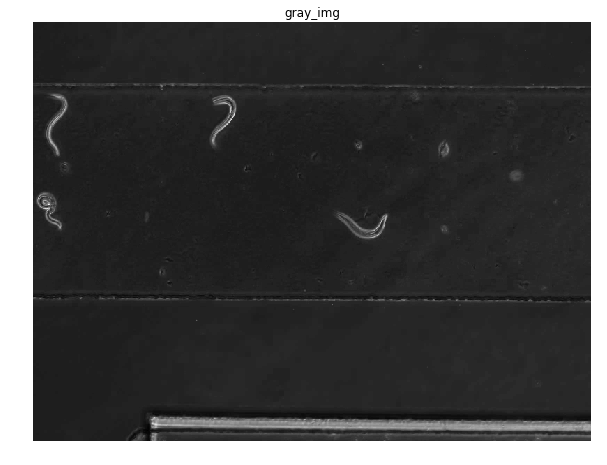

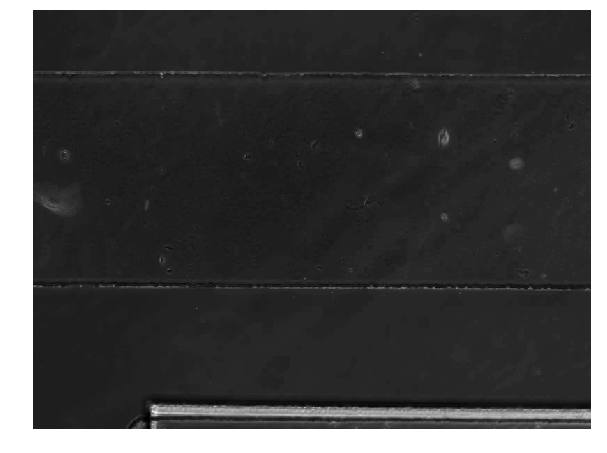

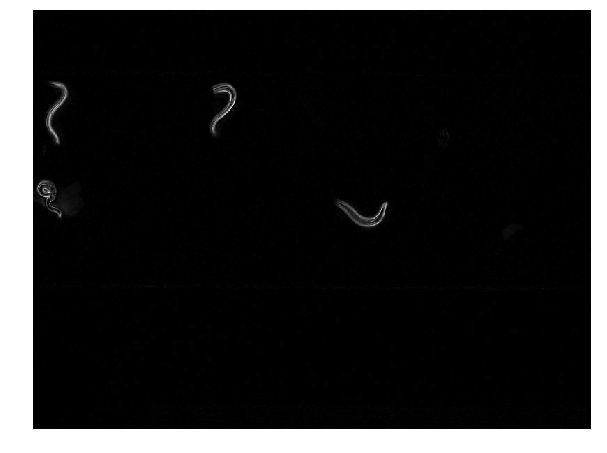

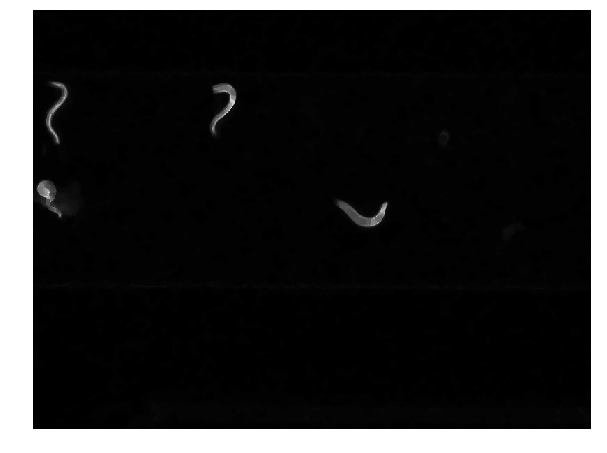

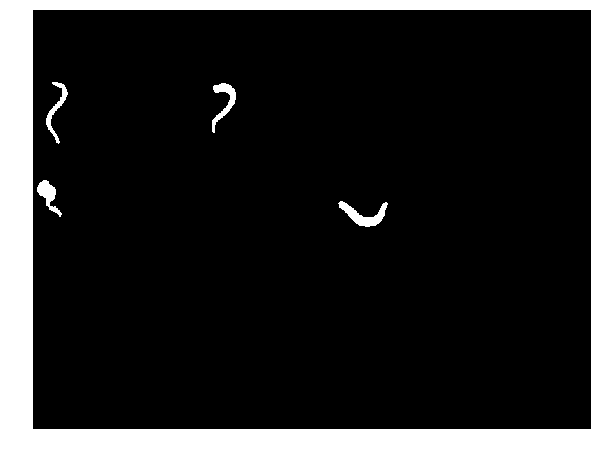

In [3]:
frames=frame_factory(params['video_path'])
print(frames[0].shape)
[frames[i] for i in range(625)]#获取某一帧的图片，遍历到625是让缓存区中map（容量为20)有该图像
img,gray=resize_and_gray(frames[620],True,scale=2)
diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))# 返回指定形状和尺寸的结构元素,MORPH_ELLIPSE椭圆形
#plt_show(img)
plt_show(gray,'gray_img')
plt_show(fgbg.getBackgroundImage())
plt_show(diff)
closing = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel,iterations = 2)#形态学闭运算，先膨胀后腐蚀，填充前景中的小洞
plt_show(closing)
otsu = thresh_otsu(closing)
plt_show(otsu)

使用形态学闭运算，在图中所有轮廓中取出大于某一阈值的轮廓们，在一张白画布上画出图形，并显示

In [4]:
frames=frame_factory(params['video_path'])
img, gray = resize_and_gray(frames[1], True, scale = 2)
diff = cv2.absdiff(gray, fgbg.getBackgroundImage())
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
closing = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel)
ostu = thresh_otsu(closing)
#####parse image####
(_,contours,_) = cv2.findContours(ostu.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask = np.zeros(ostu.shape, dtype=ostu.dtype)
mask = np.stack([mask,mask,mask], axis = 2)
# for i,contour in enumerate(contours):
#     if cv2.contourArea(contour)>200:
#         print(i)

cv2.drawContours(mask, contours, 33, (255,0,0), cv2.FILLED)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [5]:
while(1):
    cv2.imshow('ostu', np.array(mask))
    k = cv2.waitKey(1)
    if k == 27:
        break
cv2.destroyAllWindows()

## 完成整个1、2模块
# ==>对整个视频中的线虫轮廓进行绘制，并绘制质心点，存储每帧图片中的：满足阈值条件的轮廓个数、质心位置、轮廓面积、轮廓二值化图像、矩形边界
以填充模式绘制图像轮廓，并给出图像质心
保存线虫轮廓：数目、质心、面积、轮廓、边界矩阵

In [6]:
frames=frame_factory(params['video_path'])
#[frames[i] for i in range(270)]
print(frames.size)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('output.avi',fourcc, 10, (800,600))
worm_data_list=[]
for i in range(0,frames.num_frames):
    img,gray=resize_and_gray(frames[i],True,scale=2)
    diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))#指定腐蚀膨胀操作的椭圆核
    closing = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel)
    #cv2.putText(otsu, 'frame index: ' + str(i), (40, 40), 2, 2, (0,0,0), thickness = 2)
    otsu = thresh_otsu(closing)
    #得到二值化处理后的背景图
    counts,gravity,areas,cnts,boundboxs,mask=parse_image(otsu,min_area=200)
    #print(counts)
    cv2.imshow('otsu',concatenate(img,otsu))
    worm_data_list.append((counts,gravity,areas,cnts,boundboxs))
    videoWriter.write(mask)
    #print(mask.shape)
    cv2.imshow('bs',np.concatenate([img,mask],axis=1))
    k = cv2.waitKey(1) 
    if k == 27:
        break
    else:
        continue
cv2.destroyAllWindows()
videoWriter.release()
np.save('worm_data.npy',worm_data_list)

(1600, 1200)


# 线虫追踪模块

In [6]:
#################################################################################
#   Worm tracking code block
#################################################################################
worm_data_list=np.load('worm_data.npy')
track.track_id=0
track_list=[]
new_worm_list=[]
counts,gravity,areas,cnts,boundboxs = worm_data_list[0]#单个图片中有几只线虫，它们的质心和面积、轮廓信息
new_worm_list.append((counts, gravity, areas, cnts, boundboxs, np.arange(counts)))

# print(new_worm_list[-1][0],new_worm_list[-1][5])#最后一组数据中的 np.arange(counts)，counts是个数，此处需要索引和gravity对应

for i in range(counts):
    track_list.append(track(0,i))
for frame_index in range(1,len(worm_data_list)):#在所有张图片中遍历
    counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur =worm_data_list[frame_index]
#     print(frame_index,"************",counts_cur,counts)
    min_dist_index, new_track = worm_tracking((counts,gravity,areas),(counts_cur,gravity_cur,areas_cur))
    #获取的index是一个dict,value为真正的index
    obj_track_id={}
#     print(min_dist_index, new_track, new_worm_list[-1][5])
#     break
    
    for key, value in min_dist_index.items():#items获取字典的key和value值
        track_id = new_worm_list[-1][5][key]
        if value < 100 and frame_index != len(worm_data_list)-1:#100是设定的阈值参数==>utils.py
            track_list[track_id].add_track(value)
            obj_track_id[value] = track_id
        else:
            track_list[track_id].stop(frame_index - 1)
           
            #if track_list[track_id].num_frames >5:
              
    for it in new_track:
        track_list.append(track(frame_index,it))
        obj_track_id[it] = track.track_id-1
        #print("new_track",frame_index)
    track_id_list = [iu for it,iu in obj_track_id.items()]
    #print("obj_track_id",obj_track_id,"track_id_list",track_id_list)
    new_worm_list.append((counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur, np.array(track_id_list)))
    counts,gravity,areas,cnts,boundboxs = counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur
###############################################################################
#   Save the tracking data
###############################################################################
track_list = filter(lambda x: x.num_frames>10,track_list)
track_list = list(track_list)
track_id_list=[it.track_id for it in track_list]
print(track_id_list)
track_id_map={}
i=0
for it in track_id_list:
    track_id_map[it] =i
    i+=1
print(track_id_map)

track_data = []
for it in track_list:
    contour_squence = []
    ske_len_squence  = []
    
    skeleton_squence =[]
    
    cnt_side1_squence = []
    cnt_side2_squence = []
    cnt_area_squence = []
    angle_squence =[]
    prev_skeleton = np.zeros(0)
    for i in range(it.begin, it.end+1):
        #assert(it.track_id== new_worm_list[i][5][it.inter_frames_index[i - it.begin]])
        cnt = new_worm_list[i][3][it.inter_frames_index[i - it.begin]]
        skeleton, ske_len, cnt_side1, cnt_side2, cnt_widths, cnt_area = getSkeleton(cnt,  prev_skeleton=  prev_skeleton)
        
        angle = get_angle(skeleton) if len(skeleton) !=0 else None
        angle_squence.append(angle)
        
        prev_skeleton = skeleton
        
        contour_squence.append(cnt)
        ske_len_squence.append(ske_len)
        skeleton_squence.append(skeleton)
        cnt_side1_squence.append(cnt_side1)
        cnt_side2_squence.append(cnt_side2)
        cnt_area_squence.append(cnt_area)
    track_data.append(np.array([track_id_map[it.track_id],
                                it.num_frames,          it.begin,          it.end,
                                np.array(contour_squence),
                               np.array(ske_len_squence,dtype=np.object),
                               np.array(skeleton_squence),
                               np.array(cnt_side1_squence),
                               np.array(cnt_side2_squence),
                               np.array(cnt_area_squence,dtype=np.object),np.array(angle_squence)],dtype = np.object))
#######################################################################
#
########################################################################
frame_data=[]
for frame_index in range(0, len(new_worm_list)):
    counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur, track_id_list = new_worm_list[frame_index]
    track_id_list = [track_id_map.get(it,-1) for it in track_id_list]
    
    skeletons = [track_data[it][6][frame_index - track_data[it][2]] if it !=-1 else np.zeros(0) for it in track_id_list]
    
    angles = [track_data[it][10][frame_index-track_data[it][2]] if it !=-1 else None for it in track_id_list]
    
    length = [track_data[it][5][frame_index-track_data[it][2]] if it !=-1 else None for it in track_id_list]
    
    frame_data.append([counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur, track_id_list,
                        np.array(skeletons,dtype= np.object),np.array(angles,dtype=np.object),np.array(length,dtype=np.object)])
    
    
np.save('frame_data.npy',frame_data)
# data_field in frame_data
#0      1        2     3    4         5             6         7      8
#conuts gravitys areas cnts boundboxs track_id_list skeletons angles length
np.save('track_data.npy',track_data)
# data field in track_data
#0        1          2     3   4               5               6                7             8             9            10
#track_id num_frames begin end contour_squence ske_len_squence skeleton_squence side1_squence side2_squence area_squence angle_sq

[0, 3, 6, 7, 9, 10, 11]
{0: 0, 3: 1, 6: 2, 7: 3, 9: 4, 10: 5, 11: 6}


In [7]:
frames=frame_factory('output.avi')
imgs = frame_factory(params['video_path'])

fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('wormtracking.avi',fourcc, 10, (800*2,600))
print(frames.num_frames)
new_worm_list =np.load('frame_data.npy')
for i in range(frames.num_frames-1):
    counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur,track_id,skeletons, angles ,lengths =new_worm_list[i]
    img = frames[i]
    orgin_img ,_= resize_and_gray(imgs[i],True,scale=2)
    #print(skeletons[0])
    for it in range(counts_cur):
        x,y,w,h =boundboxs_cur[it]
        track_worm_id = track_id[it]
        angle = str(angles[it])[:6] if angles[it] else 'None'
        length =str(lengths[it])[:5] if lengths[it] else 'None'
        #cv2.putText(img, 'Frame index: ' + str(i), (10, 12), 4, 0.5, (90,120,255), thickness = 1)
        cv2.putText(img, 'TrackID: ' + str(track_worm_id), (x-14, y-4), 4, 0.5, (255,255,255), thickness = 1)
        cv2.putText(img, 'angle: ' +angle, (x-14, y-24), 4, 0.5, (255,255,255), thickness = 1)
        cv2.putText(img, 'length: ' + length, (x-14, y-44), 4, 0.5, (255,255,255), thickness = 1)
        img = add_arrow(img,skeletons[it]) if len(skeletons[it])!=0   else img#弯曲角和弯曲节调整、以及添加颜色矢量
    showimg = np.concatenate((orgin_img,img),axis=1)
    cv2.imshow('img',showimg)
    cv2.imshow('worm',img)
    videoWriter.write(showimg)
    k = cv2.waitKey(0) 
    if k == 27:
        break
    else:
        continue
cv2.destroyAllWindows()
videoWriter.release()

35


D:\JetBrains\Anaconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [9]:
plt_show(frames[230])

AssertionError: 